In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

from astropy import units as u
import uproot
from astropy.coordinates import Angle, SkyCoord
from regions import PointSkyRegion

from gammapy.datasets import MapDataset
from gammapy.makers import MapDatasetMaker
from gammapy.data import Observation, DataStore, ObservationFilter
from IPython.display import display, Math
from gammapy.maps import Map, WcsGeom, MapAxis, RegionGeom
from gammapy.datasets import Datasets, SpectrumDatasetOnOff, SpectrumDataset, FluxPointsDataset
from gammapy.makers import SpectrumDatasetMaker, PhaseBackgroundMaker
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import PowerLawSpectralModel, LogParabolaSpectralModel, ExpCutoffPowerLawSpectralModel, PiecewiseNormSpectralModel
from gammapy.modeling.models import SkyModel, Models

# The Geminga pulsar (PSR Jxxx)
- Position
- Energy axis: true energy axis + reconstructed (estimated) energy axis

**Note: the energy binning should be the same as those used in the DL3 converter for
IRF computation**

In [2]:
# Geminga
target_position = SkyCoord(ra=98.475638, dec=17.770253, unit="deg", frame="icrs")
on_region = PointSkyRegion(target_position)

ereco = np.geomspace(5*u.GeV,50*u.TeV,30+1)
etrue = np.geomspace(5*u.GeV,50*u.TeV,int(30/1.4 + 1))

energy_axis = MapAxis.from_energy_edges(ereco,name="energy",unit='GeV')
energy_axis_true = MapAxis.from_energy_edges(etrue,name='energy_true',unit='GeV')

### Load MAGIC DL3 data

In [3]:
data_store = DataStore.from_dir("../../Geminga_gammapy/addphase00")
observations = data_store.get_observations(required_irf="point-like")
print(data_store)

Data store:
HDU index table:
BASE_DIR: ../../Geminga_gammapy/addphase00
Rows: 1350
OBS_ID: 5059985 -- 5080559
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti', 'rad_max']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti', 'rad_max_2d']


Observation table:
Observatory name: 'N/A'
Number of observations: 270



In [4]:
t_eff = 0
for i in range(len(observations)):
    t_eff += observations[i].observation_live_time_duration
print('Effective time: ', t_eff, ' or ', t_eff.to(u.h))

Effective time:  286307.3343729455 s  or  79.52981510359596 h


### Data reduction

In [5]:
# the geometry defines the array of ON counts
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true = energy_axis_true)
dataset_maker = SpectrumDatasetMaker(containment_correction=False, selection=["counts", "exposure", "edisp"])

# signal and background phase regions of Geminga
on_phase = (0.550, 0.642)
off_phase = (0.7, 0.95)
bkg_maker_phase = PhaseBackgroundMaker(on_phase, off_phase, phase_column_name='PHASE')


In [ ]:
datasets00 = Datasets()

for observation in observations:
    # fill the ON counts array and compute the IRF at the observation offset
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    # use off phase region for background estimation
    dataset_on_off = bkg_maker_phase.run(dataset, observation)
    datasets00.append(dataset_on_off)

In [7]:
dataset00 = datasets00.stack_reduce()

### Results

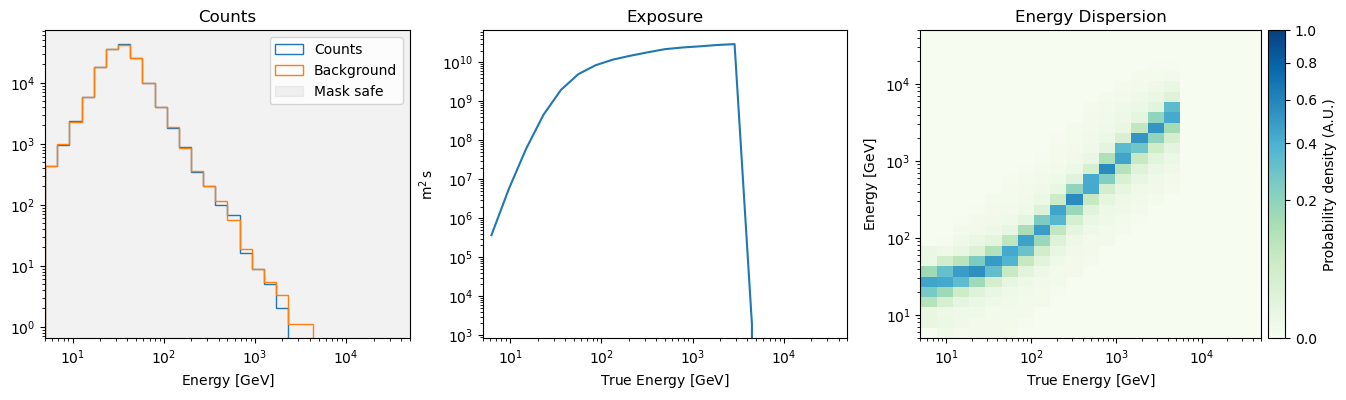

In [9]:
dataset00.peek()

Text(0, 0.5, 'Counts')

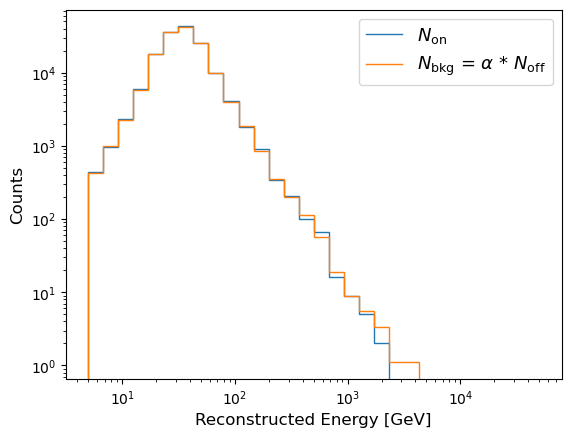

In [10]:
fig, ax = plt.subplots()
bin_edges = dataset00.counts.geom.axes['energy'].edges
ax.stairs(dataset00.counts.data[:,0,0], bin_edges.value, label='$N_{\mathrm{on}}$')
ax.stairs(dataset00.background.data[:,0,0], bin_edges.value, label=r'$N_{\mathrm{bkg}}$ = $\alpha$ * $N_{\mathrm{off}}$')

ax.set_yscale("log")
ax.set_xscale("log")
ax.legend( fontsize=13)
ax.set_xlabel("Reconstructed Energy [GeV]", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)

Text(0, 0.5, 'Counts')

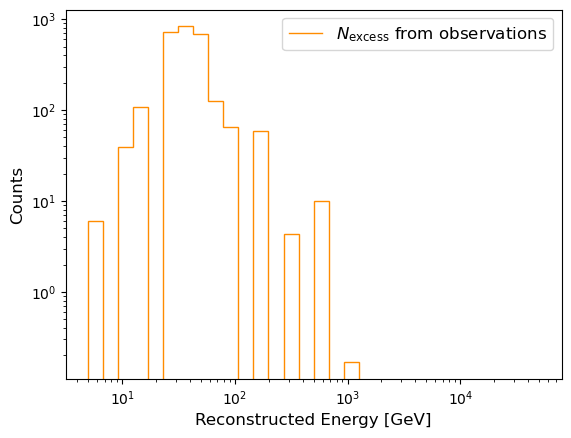

In [11]:
fig, ax = plt.subplots()
bin_edges = dataset00.counts.geom.axes['energy'].edges
ax.stairs(dataset00.excess.data[:,0,0], bin_edges.value, color='darkorange', label='$N_{\mathrm{excess}}$ from observations')

ax.set_yscale("log")
ax.set_xscale("log")
ax.legend( fontsize=12)
ax.set_xlabel("Reconstructed Energy [GeV]", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)

### Energy migration matrix

[]

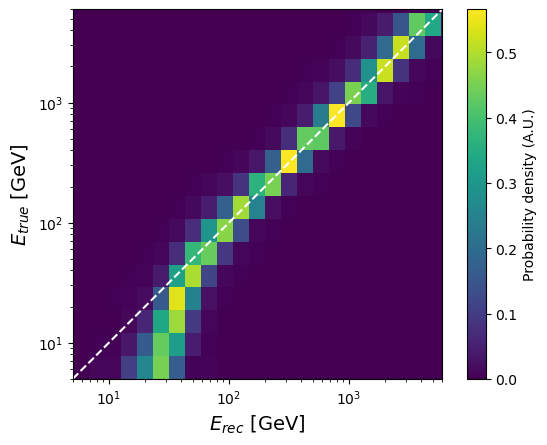

In [12]:
fig, ax = plt.subplots()

kernel = dataset00.edisp.get_edisp_kernel()

data = kernel.data
energy_axis_true = kernel.axes['energy_true']
energy_axis = kernel.axes['energy']

caxes = ax.pcolormesh(energy_axis.edges, energy_axis_true.edges, data, cmap='viridis')
cbar = plt.colorbar(caxes, ax=ax)
cbar.set_label("Probability density (A.U.)")

ax.set_xlabel("$E_{rec}$ [GeV]", fontsize=14)
ax.set_ylabel("$E_{true}$ [GeV]", fontsize=14)

# Plot the line (y = x)
min = 5
max = 6e3
ax.plot([min, max], [min, max], color='white', linestyle='--')
ax.set_xlim([min, max])
ax.set_ylim([min, max])
ax.set_aspect('equal', adjustable='box')
ax.loglog()